# Compare chemical tracers form NO-EF, w-EF, with idealized EEIV and with closure

In [1]:
clear
homedir = getenv('HOME');
workdir = getenv('WORK');
scradir = getenv('SCRATCH');
addpath(genpath([homedir '/work_MOM']));
addpath(genpath([homedir '/mytoolbox']));
addpath(genpath([homedir '/MyFuncs']));

## get GS core

In [2]:
yr_s = 21;
[day_s, day_e, dt] = deal(1, 365*2, 1);   
t_al = day_s:dt:day_e;
nt_al = length(t_al);

ds_GS = load('GScore_mom_unsm_wide.mat'); % GScore_mom_unsm or GScore_mom
[ii_GS, jj_GS] = deal(ds_GS.ii, ds_GS.jj);
[x_GSC_t, y_GSC_t, id_lat_spdt] = deal(zeros(length(ii_GS),nt_al));

for it = 1:nt_al
    it_ds = find(t_al(it) == ds_GS.t_al);
    id_lat_spdt(:,it) = ds_GS.id_lat_spdt(:,it_ds);
    x_GSC_t(:,it) = ds_GS.x_GSC_t(:,it_ds);
    y_GSC_t(:,it) = ds_GS.y_GSC_t(:,it_ds);
end
x_GSC_m = ds_GS.x_GSC_m;
y_GSC_m = ds_GS.y_GSC_m;

[grid_l, ~, ~] = read_grid_MOM('/glade/work/yueyanglu/MOM6_exp/mom_lowRES/'); 
nk = 3;
grid_al = {grid_l, grid_l, grid_l, grid_l, grid_l, grid_l};
fldnm = 'tr1';

## read tr

In [3]:
E_al = { [workdir '/MOM6_OUT/tr_off_64_180d/sols_cfc11/tr_noforc/'], ...
         [workdir '/MOM6_OUT/tr_off_64_180d/sols_cfc11/tr_forcprog_addrel10d_norel/'], ...
         [workdir '/MOM6_OUT/tr_off_64_180d/sols_cfc11/tr_noforc_paramka400Chidotn_SIGNFIT_usefitchin/'],...
         [workdir '/MOM6_OUT/tr_off_64_180d/sols_cfc11/tr_noforc_paramka400Chidotn_chinclosure1d_alpha/']
         };
initfnm_al = {[workdir '/MOM6_OUT/forc_uvh_64/ICs/trac_CFC11_64.nc'],...
            [workdir '/MOM6_OUT/forc_uvh_64/ICs/trac_CFC11_64.nc'],...
            [workdir '/MOM6_OUT/forc_uvh_64/ICs/trac_CFC11_64.nc'],...
            [workdir '/MOM6_OUT/forc_uvh_64/ICs/trac_CFC11_64.nc']};   
hdir_al = {[workdir '/MOM6_OUT/forc_uvh_64/sol_h_180d/'],...
           [workdir '/MOM6_OUT/forc_uvh_64/sol_h_180d/'],...
           [workdir '/MOM6_OUT/forc_uvh_64/sol_h_180d/'],...
           [workdir '/MOM6_OUT/forc_uvh_64/sol_h_180d/']};

titles = {'NO\_EF', 'W\_EF', 'IDL\_EEIV', 'CLOSURE'};

ncel = numel(E_al);

%---- initials
[cinit_al, cminit_al] = deal( cell(1,ncel) ); 
% ---- read init dist
for icel = 1:ncel
    cinit_al{icel} = ncread(initfnm_al{icel},fldnm);
    h_initfnm = [hdir_al{icel} 'h_snap__0021_001_00.nc'];
    hinit = ncread(h_initfnm, 'h');
    cminit_al{icel} = cinit_al{icel} .* hinit .* grid_al{icel}.Ah;
end

%-----------------------
[c_al, cm_al, vol_al] = deal(cell(1,ncel)); 
for it = 1:nt_al
   
    % current time
    t1 = t_al(it);
    [yrstr, dystr, hrstr] = get_timestr(t1, yr_s); % for k and tracer
    
    % read all runs
    for icel = 1:ncel
        c_fnm = [E_al{icel} 'tr__' yrstr '_' dystr '_' hrstr '.nc'];
        h_fnm = [hdir_al{icel} 'h_snap__' yrstr '_' dystr '_' hrstr '.nc'];
        % fnm
        c3d = ncread(c_fnm,fldnm);
        h3d = ncread(h_fnm,'h');
        
        % delC := dc/dx on u/v [c/m]
        [cx,cy] = calc_GxGy_CG(c3d(:,:,1),ones(grid_l.nih,grid_l.njh),grid_l.dxCu,grid_l.dyCu,grid_l.dxCv,grid_l.dyCv,0); 
        cx([1 end],:) = 0; cy(:,[1 end]) = 0;
        [cx_p,cy_p] = uv2p_CG(cx,cy);
        
        % [c] and [c*Vol]
        c_al{icel}(:,:,:,it) = c3d;
        vol_al{icel}(:,:,:,it) = h3d.* grid_al{icel}.Ah; %[m3]
        cm_al{icel}(:,:,:,it) = c3d .*h3d.*grid_al{icel}.Ah;
        cy2_al{icel}(:,:,it) = cy_p.^2;
    end
end

## calc spatial mean (dc/dy)^2

In [4]:
[x, y] = deal(grid_al{1}.lonh, grid_al{1}.lath);
xlims = [0 3000]; ylims = [1600 2400];
[~, ii_s] = min(abs(x - xlims(1))); [~, ii_e] = min(abs(x - xlims(2)));
[~, jj_s] = min(abs(y - ylims(1))); [~, jj_e] = min(abs(y - ylims(2)));
[ii_rec, jj_rec] = deal(ii_s:ii_e, jj_s:jj_e);

fld_do = cy2_al; % cy_al delc_norm
% idx for GS core
for iGS = 1:length(x_GSC_m)
    [~, ii_GS_est(iGS)] = min(abs(x - x_GSC_m(iGS)));
    [~, jj_GS_est(iGS)] = min(abs(y - y_GSC_m(iGS)));
    for it = 1:nt_al
        [~, ii_GS_est_t(iGS,it)] = min(abs(x - x_GSC_t(iGS,it)));
        [~, jj_GS_est_t(iGS,it)] = min(abs(y - y_GSC_t(iGS,it)));
    end
end
% 
for icel = 1:ncel
    for it = 1:nt_al
        % fxy = fld_do{icel}(ii_rec,jj_rec,it);
        % ftest = cy_al{icel}(ii_rec,jj_rec,it);
        % if icel<=3; fxy(ftest>0) = NaN; end
        % mean_box{icel}(it) = mean(fxy,[1 2],'omitnan') ;
        %
        fxy = (fld_do{icel}(ii_GS_est(1:end),jj_GS_est(1:end),it));
        mean_GSC{icel}(it) = mean(fxy,[1 2],'omitnan') ;
    end
end

## calc the tracer mass averaged between GS core and rectangle boundary

In [5]:

% for each longitude at GS core, get jj's N and S of the jet
ik = 1;
[fld_sum_N, fld_sum_S, vol_sum_N, vol_sum_S, c_mean_N, c_mean_S] = deal(cell(1,ncel)); 
[fld_sum_N(:), fld_sum_S(:), vol_sum_N(:), vol_sum_S(:), c_mean_N(:), c_mean_S(:)] = deal({zeros(1,nt_al)});
[jj_N, jj_S] = deal( cell(ncel,length(ii_GS),nt_al) ); 

ifsub = 0; % summed c or c-anomaly
for icel = 1:ncel
    
    for it = 1:nt_al
        % fxy = squeeze(c_al{icel}(:,:,ik,it) - ifsub * cinit_al{icel}(:,:,ik));
        fxy = squeeze(cm_al{icel}(:,:,ik,it));
        cxy = squeeze(c_al{icel}(:,:,ik,it));

        numsum_N = 0;
        numsum_S = 0;
        for i = 1:length(ii_GS)
            jj_N{icel,i,it} = jj_GS(id_lat_spdt(i,it))+1 : jj_rec(end);
            jj_S{icel,i,it}  = jj_rec(1) : jj_GS(id_lat_spdt(i,it))-1;

            % sum by looping over each lat
            fld_sum_N{icel}(it) = fld_sum_N{icel}(it) + sum( fxy(ii_GS(i),jj_N{icel,i,it}) );
            fld_sum_S{icel}(it) = fld_sum_S{icel}(it) + sum( fxy(ii_GS(i),jj_S{icel,i,it}) );
            vol_sum_N{icel}(it) = vol_sum_N{icel}(it) + sum( vol_al{icel}(ii_GS(i),jj_N{icel,i,it},ik,it) );
            vol_sum_S{icel}(it) = vol_sum_S{icel}(it) + sum( vol_al{icel}(ii_GS(i),jj_S{icel,i,it},ik,it) );
            %
            c_mean_N{icel}(it) = c_mean_N{icel}(it) + sum( cxy(ii_GS(i),jj_N{icel,i,it}) );
            c_mean_S{icel}(it) = c_mean_S{icel}(it) + sum( cxy(ii_GS(i),jj_S{icel,i,it}) );
            numsum_N = numsum_N + length(jj_N{icel,i,it});
            numsum_S = numsum_S + length(jj_S{icel,i,it});
        end
        fld_sum_N{icel}(it) = fld_sum_N{icel}(it) / vol_sum_N{icel}(it);
        fld_sum_S{icel}(it) = fld_sum_S{icel}(it) / vol_sum_S{icel}(it);
        c_mean_N{icel}(it) = c_mean_N{icel}(it) / numsum_N;
        c_mean_S{icel}(it) = c_mean_S{icel}(it) / numsum_S;
        
    end % it
end % icel

## select y-sections

In [6]:
% ------------------ for cross section
x_section_al = 500:500:2500; % km 
ylims_crs = [1300 2700];
nsecs = numel(x_section_al);
for icel = 1:nsecs
    x_section = x_section_al(icel);
    [~, ii_sec_al(icel)] = min(abs(x - x_section));
end

% ----- time mean 2d c
ik = 1;
it = 1:nt_al;
for icel = 1:ncel
    fld2d_al{icel} = squeeze(mean(c_al{icel}(:,:,ik,it),4));
end

# plot top: tracers, mid: mean tracers, and bot: y-sections

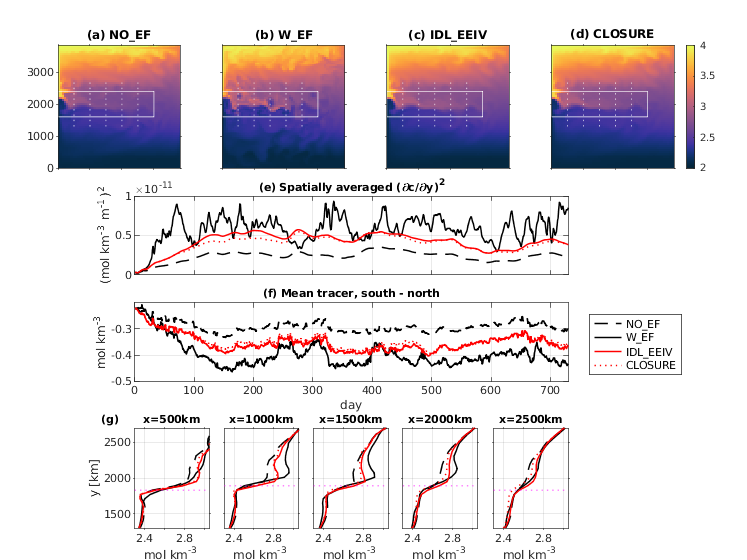

In [7]:
% save('data_fig_trexps_PT.mat','t_al','c_al','fld_sum_N','fld_sum_S','titles',...
%         'x','y','xlims','ylims','x_GSC_m','y_GSC_m')

x_top = 0.05; y_top = 0.7; h_top = 0.22; w_top = h_top; dx_top = 0.0;
x_bot = 0.18; y_bot = 0.32; h_bot = 0.14; w_bot = 0.58; dy_bot = 0.05;
x_crs = x_bot; y_crs = 0.056; h_crs = 0.18; w_crs = 0.1; dx_crs = 0.02;
% 
pos_top = { [x_top y_top w_top h_top], [x_top+w_top y_top w_top h_top], ...
            [x_top+2*w_top y_top w_top h_top], [x_top+3*w_top y_top w_top h_top]};
pos_bot = { [x_bot y_bot+h_bot+dy_bot w_bot h_bot], ...
            [x_bot y_bot w_bot h_bot]};
pos_crs = { [x_crs                y_crs w_crs h_crs], ...
            [x_crs+w_crs+dx_crs   y_crs w_crs h_crs], ...
            [x_crs+2*(w_crs+dx_crs) y_crs w_crs h_crs], ...
            [x_crs+3*(w_crs+dx_crs) y_crs w_crs h_crs], ...
            [x_crs+4*(w_crs+dx_crs) y_crs w_crs h_crs]};
ftsz_title = 8;
ftsz_axes = 8;

% ------------------ plot 2d c ------------------
ik = 1; it = 361; t_al(it);
clim = [2 4]; cmap = 'thermal';
font = 'DejaVu Sans';
figure('DefaultTextFontName', font, 'DefaultAxesFontName', font);
% 
inds_al = {'(a)','(b)','(c)','(d)'};
for icel = 1:ncel
    % axes(ha(icel))
    subplot('Position',pos_top{icel});
    
    f_do = c_al{icel}(:,:,ik,it); 
    % f_do = cm_al{icel}(:,:,1,it);% 
    imagescn(x, y, f_do'); set(gca,'tickdir','out','xtick',[1e3:1e3:3e3]);
    cmocean(cmap); axis square; caxis(clim)
    title([inds_al{icel} ' ' titles{icel}],'fontsize',ftsz_title)
    for icel_crs = 1:nsecs
        vhd = vline(x_section_al(icel_crs),':w');
        vhd.YData = ylims_crs;
    end
    hd = rectangle('Position',[xlims(1) ylims(1) xlims(end)-xlims(1) ylims(end)-ylims(1)]); 
    hd.EdgeColor = 'w';
    if icel >= 2; set(gca,'yticklabel',''); end
    % if icel == 1; set(gca,'yticklabel',{'11'}); end
    set(gca,'xticklabel','','xtick',0:1e3:3e3,'ytick',0:1e3:3e3,'FontSize',ftsz_axes);
end
cb = colorbar;
cb.XTick = clim(1):.5:clim(2);
cb.Position = [x_top+ncel*w_top-.01 y_top 0.01 h_top];

% --------------- plot the integrated temp vs time ---------------
linewidth = 1.1;
styles = {'k--','k-','r-', 'r:'}; 
% 
subplot('Position',pos_bot{1});
for icel = 1:ncel
    plot(t_al,mean_GSC{icel},styles{icel},'linewidth',linewidth);
    mean(mean_GSC{icel}(30:end));
    hold on
end
set(gca,'XLim',[0 t_al(end)],'FontSize',ftsz_axes)
set(gca,'xticklabel','')
grid on
ylabel('(mol km^{-3} m^{-1})^2')
ldg = legend(titles,'location','northeastoutside','NumColumns',1,'fontsize',8);
ldg.ItemTokenSize = [20 10];
ldg.Position = [0.8    0.35    0.1    0.07];
title('(e) Spatially averaged (\partial{c}/\partial{y})^2','fontsize',ftsz_title)

% ---------------
subplot('Position',pos_bot{2});
for icel = 1:ncel
    fplt = fld_sum_S{icel} - fld_sum_N{icel};
    plot(t_al,fplt, styles{icel}, 'linewidth', 1.2)
    % mean(fplt(30:end))
    hold on
end
grid on
hold off
set(gca,'XLim',[0 t_al(end)],'ylim',[-0.5 -0.2],'FontSize',ftsz_axes)
xlabel('day')
ylabel('mol km^{-3}')
% ldg = legend(titles,'location','southeast','NumColumns',4,'fontsize',6);
% ldg.ItemTokenSize = [20 10];
title('(f) Mean tracer, south - north','fontsize',ftsz_title)

% --------------------- plot y-sections --------------
nplts = 5;
for icel = 1:nplts

    [ii_sec, x_section] = deal(ii_sec_al(icel), x_section_al(icel));
    
    % axes(ha(icel))
    subplot('Position',pos_crs{icel});
    for icel_in = 1:ncel
        plot(fld2d_al{icel_in}(ii_sec,:), y, styles{icel_in}, 'linewidth', linewidth);
        hold on
    end  
    %
    % [~, ii_GSC] = min(abs(x_GSC_t(:,it) - x_section));
    % hline(y_GSC_t(ii_GSC,it),'--m','HandleVisibility','off');
    [~, ii_GSC] = min(abs(x_GSC_m - x_section));
    hline(y_GSC_m(ii_GSC),':m','HandleVisibility','off');
    
    ax = gca;
    ax.XGrid = 'on'; ax.YGrid = 'on';
    ax.XLim = [2.3 3.05];
    ax.XTick = 2.4:.2:3;
    ax.XTickLabel = {'2.4','','2.8',''};
    xtickangle(0);
    ax.YLim = ylims_crs;
    ax.TickDir = 'out';
    ax.FontSize = ftsz_axes;
    if icel > 1; ax.YTickLabel = ''; end
    if icel == 1
        ylabel('y [km]')
        ax = gca;
        hb = subplotlabel(ax,'g','location','northwestoutside',...
            'offset',[-0.45 0.02],'Prefix','(','Postfix',')','fontsize',ftsz_title,'FontWeight','bold');        
    end
    xlabel('mol km^{-3}')
    title(['x=' num2str(x_section) 'km'],'fontsize',ftsz_title)
end
hold off

% ---
set(gcf,'PaperPositionMode','auto'); 
fignm = [homedir '/work_MOM/figures/fig12_trexps_CFC'];
% exportgraphics(gcf,[fignm '.pdf'], 'BackgroundColor','white','ContentType','vector')
